<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/jax_implicit_cloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install meshzoo

In [2]:
import numpy as np
import jax.numpy as jnp
import jax.scipy.sparse
from jax import grad, jit, vmap, hessian
from jax import jacfwd, jacrev
from jax.lax import cond, scan
from jax.ops import index, index_add, index_update
import meshzoo
from functools import partial
import plotly.graph_objs as go
import plotly.io as pio

pio.templates.default = "plotly_white" # also nice: "simple_white"
# pio.renderers.default = "colab"
# pio.renderers.default = "svg" # static plots for Github
pio.renderers.default = "notebook_connected" # interactive plots for NBViewer

## Getting the mesh
Baraff & Witkin simulate cloth as a 3D triangle mesh, but with a 2D rest state. 
This reflects the fact that clothes are made from pieces cut out of 2D sheets of fabric.

In [3]:
rest_positions_2D, triangles = meshzoo.rectangle_tri(
    (0.0, 0.0),
    (1.0, 1.0),
    n=4,
    variant="zigzag",  # or "up", "down", "center"
)

rest_positions_2D = jnp.array(rest_positions_2D)
amount_of_triangles = triangles.shape[0]

print("There are", amount_of_triangles, "triangles in the mesh.")
print("The first triangle contains vertices:", triangles[0])

There are 32 triangles in the mesh.
The first triangle contains vertices: [0 1 6]


## Initializing the 3D positions

In [4]:
amount_of_vertices = rest_positions_2D.shape[0]
positions_z = np.zeros(amount_of_vertices)

positions = jnp.column_stack([rest_positions_2D, positions_z])
velocities = jnp.zeros_like(positions)

print("There are", amount_of_vertices, "vertices in the mesh.")
positions.shape

There are 25 vertices in the mesh.


(25, 3)

In [5]:
def get_vertices_go(positions, color='deeppink'):
    x, y, z = positions.T
    vertices_go = go.Scatter3d(x=x, y=y, z=z,
                               mode='markers+text',
                               marker=dict(size=5, color=color),
                               text=[str(i) for i in range(len(positions))])
    return vertices_go

def get_mesh_go(positions, triangles, color='deepskyblue', opacity=1.0):
    x, y, z = positions.T
    i, j, k = triangles.T
    mesh_go = go.Mesh3d(x=x, y=y, z=z,
                        i=i, j=j, k=k,
                        color=color,
                        opacity=opacity,
                        hoverinfo='skip')
    return mesh_go

def make_fig(data, 
             xrange=[-0.6, 1.6], 
             yrange=[-1.1, 1.1], 
             zrange=[-2, 0.25], 
             eye=dict(x=-1.0, y=-1.0, z=1.0),
             center=None,
             up=None):
    fig = go.Figure(data=data)
    fig.update_layout(scene = dict(
        xaxis=dict(range=xrange, autorange=False),
        yaxis=dict(range=yrange, autorange=False),
        zaxis=dict(range=zrange, autorange=False),
        aspectmode='cube',
        camera = dict(eye=eye, center=center, up=up)
    ))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)) # tight layout
    return fig

data = [get_vertices_go(positions),
        get_mesh_go(positions, triangles)]

make_fig(data).show()

## Defining the energy of a single triangle.

In [6]:
triangle = jnp.array([[0, 1, 2]])
triangle_positions = jnp.array([[0.0, 0.0, 0.0],
                                [1.0, 0.0, 0.0],
                                [0.5, 0.5, 0.0]])

triangle_rest_positions_2D = jnp.array([[0.0, 0.0], [1.0, 0.0], [0.5, 0.5]])
triangle_positions_new = index_add(triangle_positions, index[2, 1], 0.5)

In [7]:
def deformation_gradient(vertex_positions, vertex_positions_uv):
    uv0, uv1, uv2 = vertex_positions_uv
    (u0, v0), (u1, v1), (u2, v2) = uv0, uv1, uv2

    delta_u1 = u1 - u0
    delta_u2 = u2 - u0
    delta_v1 = v1 - v0
    delta_v2 = v2 - v0

    delta_u_matrix = jnp.array([(delta_u1, delta_u2),
                               (delta_v1, delta_v2)])
    
    inverted_delta_u_matrix = jnp.linalg.inv(delta_u_matrix)

    x0, x1, x2 = vertex_positions

    delta_x1 = x1 - x0
    delta_x2 = x2 - x0

    delta_x_matrix = jnp.column_stack((delta_x1, delta_x2))

    # Equation (9) in Baraff-Witkin.
    w_uv = delta_x_matrix @ inverted_delta_u_matrix
    
    wu, wv = jnp.hsplit(w_uv, 2)

    return wu, wv

In [8]:
def triangle_area(triangle_vertices):
    v0, v1, v2 = triangle_vertices
    return jnp.linalg.norm(jnp.cross(v1 - v0, v2 - v0)) / 2.0

In [9]:
def stretch_energy(positions, rest_positions, ku, kv):
    """
    Calculates the energy due to stretching of a single triangle.

    :param positions: The current 3D positions of the 3 vertices.
    :param rest_positions: The 2D rest positions of the 3 vertices.
    :param ku: The stretch stiffness along the first 2D dimension.
    :param kv: The stretch stiffness along the second 2D dimension.
    """
    wu, wv = deformation_gradient(positions, rest_positions)
    area_uv = triangle_area(rest_positions)

    Cu = jnp.linalg.norm(wu) - 1.0
    Cv = jnp.linalg.norm(wv) - 1.0

    Eu = 0.5 * area_uv * (Cu ** 2)
    Ev = 0.5 * area_uv * (Cv ** 2)

    E = ku * Eu + kv * Ev
    return E

In [10]:
stretch_energy(triangle_positions_new, triangle_rest_positions_2D, 200.0, 200.0)
triangle_forces = -1.0 * grad(stretch_energy)(triangle_positions_new, triangle_rest_positions_2D, 200.0, 200.0)
print(triangle_forces)

[[  -0.   50.   -0.]
 [  -0.   50.   -0.]
 [  -0. -100.   -0.]]


In [11]:
def get_cones_go(positions, directions,):
    x, y, z = positions.T
    u, v, w = directions.T
    cones_go = go.Cone(x=x, y=y, z=z,
                       u=u, v=v, w=w,
                       sizemode='scaled',
                       sizeref=0.1)
    return cones_go

data = [get_vertices_go(triangle_positions_new, color='green'),
        get_vertices_go(triangle_positions),
        get_mesh_go(triangle_positions_new, triangle, opacity=0.4, color='lightblue'),
        get_mesh_go(triangle_positions, triangle, opacity=0.4),
        get_cones_go(triangle_positions_new, triangle_forces)]

cx, cy, cz = triangle_positions[2]
make_fig(data, 
         xrange=[-0.4, 1.2],
         yrange=[-0.4, 1.2],
         zrange=[-0.5, 0.5],
         eye=dict(x=1.0, y=-0.1, z=1.0)).show()

## Total energy of the cloth

In [12]:
def triangle_energy(positions, positions_uv, vertex_indices, k_stretch_u, k_stretch_v):
  uv0, uv1, uv2 = positions_uv[vertex_indices]
  x0, x1, x2 = positions[vertex_indices]
  energy = stretch_energy((x0, x1, x2), (uv0, uv1, uv2), k_stretch_u, k_stretch_v)
  return energy

In [13]:
def total_energy(positions_flat, positions_uv, triangles, k_stretch_u, k_stretch_v):

    positions = positions_flat.reshape(-1, 3) # reshape back into 3-column layout

    triangle_energy_jit = partial(triangle_energy, 
                                positions, 
                                positions_uv,
                                k_stretch_u=k_stretch_u,
                                k_stretch_v=k_stretch_v)
    
    sum = jnp.sum(vmap(triangle_energy_jit)(triangles))
    return -sum

total_energy(positions, rest_positions_2D, triangles, 200.0, 200.0)

DeviceArray(-0., dtype=float32)

In [14]:
calculate_forces = grad(total_energy)

In [15]:
calculate_force_derivatives = jacfwd(calculate_forces)
# or equivalently (I think?):
# calculate_force_derivatives = hessian(total_energy)

In [16]:
system_size = 3 * amount_of_vertices

m = 1.0 / amount_of_vertices
masses = jnp.array([m] * system_size)
M = jnp.diag(masses)

pinned_vertices = [0, 4]

S = jnp.identity(system_size)

for i in pinned_vertices:
    S = index_update(S, index[3*i:3*i+3, 3*i:3*i+3], 0.0)

# DynDef: Since S is symmetric, we could just write SAS, 
# but the transpose makes the projection a little more visually obvious.

# needed for PPCG
I = np.identity(system_size)
z = jnp.zeros(system_size)

In [17]:
steps = 500
h = dt = 0.01
time = steps * dt

standard_gravity = [0.0, 0.0, -9.81]
gravity_forces = masses * jnp.array(standard_gravity * amount_of_vertices)

def simulate_step_implicit(carry, step_number, params): 
    positions, velocities = carry

    k, rest_positions_2D, triangles = params

    f0 = calculate_forces(positions.flatten(), rest_positions_2D, triangles, k, k)
    dfdx = calculate_force_derivatives(positions.flatten(), rest_positions_2D, triangles, k, k)

    f0 = f0 + gravity_forces

    v0 = velocities.flatten()

    # Equation (16) in Baraff-Witkin.
    A = M - (h * h) * dfdx
    b = h * (f0 + h * (dfdx @ v0))

    # Prefiltering the system (from PPCG) 
    # see also: Dynamic Deformables Course Notes section 10.1.1 
    LHS = (S @ A @ S) + I - S
    c = b - A @ z
    rhs = S @ c

    LHS_func = lambda x : LHS @ x

    y = jax.scipy.sparse.linalg.cg(LHS_func, rhs)[0]

    x = y + z

    delta_v = x.reshape(-1, 3)

    velocities_new = velocities + delta_v
    positions_new  = positions + velocities_new * dt

    carry = positions_new, velocities_new
    output = positions_new
    return (carry, output)

In [18]:
def simulate_full(k, positions, velocities):
    params = k, rest_positions_2D, triangles
    simulate_step_partial = partial(simulate_step_implicit, params=params)

    carry0 = positions, velocities
    history = scan(simulate_step_partial, carry0, np.arange(steps))[1]
    return history

history = jit(simulate_full)(10000.0, positions, velocities)

In [19]:
def frame_data(positions, triangles):
    return [
       get_vertices_go(positions),
       get_mesh_go(positions, triangles)
    ]

def animate_cloth(history, triangles, dt, fps=30):

    fig = make_fig(frame_data(positions, triangles))

    fps_simulation = 1 / dt
    skip = np.floor(fps_simulation / fps).astype(np.int32)
    fps_adjusted = fps_simulation / skip
    print('fps was adjusted to:', fps_adjusted)

    fig.update_layout(updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None, dict(frame=dict(redraw=True,fromcurrent=True, mode='immediate'))]
                                        )])])

    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000.0 / fps_adjusted

    indices = np.arange(0, len(history), skip)
    frames = [go.Frame(data=frame_data(history[i], triangles)) for i in indices]

    fig.update(frames=frames)
    fig.show()

animate_cloth(history, triangles, dt)

fps was adjusted to: 33.333333333333336


(75, 75)


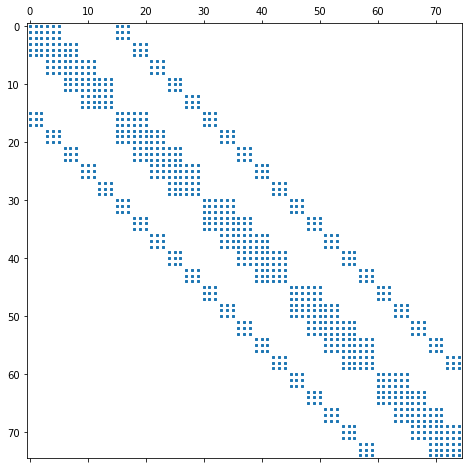

In [20]:
import matplotlib.pyplot as plt

dfdx = calculate_force_derivatives(history[-1].flatten(), rest_positions_2D, triangles, 200.0, 200.0)
print(dfdx.shape)
plt.figure(figsize=(8,8))
plt.spy(dfdx, markersize=2.8);